# Projeto Foreground Segmentation

Por Lucas Scarlato Astur

### 1.	Introdução:
O objetivo deste projeto é realizar a contagem de pessoas detectadas em um frame de vídeo. Para isto ser possível, foi implementado um modelo de segmentação de background-foreground seguindo as diretrizes do artigo Real-time Foreground-background Segmentation Using Codebook Model [1], seguido da implementação de contagem de pessoas utilizando o frame segmentado a partir da etapa anterior.

### 2.	Modelo de codebooks:
Na seção 1.2 o artigo aborda técnicas previamente utilizadas de subtração de foreground-background, aborda suas desvantagens e comenta sobre as vantagens sobre o modelo de codebooks proposto. Dentre elas, destaca-se a habilidade de lidar com background dinâmicos e se adequar a diferenças na iluminação global e local.
A ideia do codebook é que, para cada pixel, exista um codebook contendo informações (codewords) sobre aquele pixel ao longo dos frames do vídeo, como faixas de brilho e cores registrados do mesmo, além da frequência com a qual essas faixas de parâmetros aconteceram.
O modelo de codebooks divide-se em uma etapa de treinamento e uma etapa de teste, que serão discutidos nas próximas seções.


### 3.	Implementação do treinamento:
Na fase de treinamento o algoritmo monta os codebooks do video. Isso será utilizado para o algoritmo aprender características do background da imagem, para que, durante a fase de testes, o algoritmo seja capaz de segmentar presença de elementos estranhos (foregrounds) ao cenário (background). Neste caso, o objetivo é detectar pessoas no cenário aprendido durante o treinamento.
No código, esta fase é abstraída pela função train(), que recebe um conjunto de imagens a realiza a montagem do codebook de cada pixel.

### 4.	Implementação do teste:
A partir do codebok treinado, o algoritmo é alimentado por imagens, que entrarão como parâmetros na função test() e será retornado uma mascara dos objetos foreground segregados do background para cada imagem. O algoritmo, ao detectar pixels que fazem parte do background, atualiza o codebook daquele pixel, tal como ocorre na fase de treinamento.

### 5.	Contando pessoas:
Uma vez criado a mascara, é usado o cv.findcountours para contar a quantidade de blobs na imagem, o que, em situação ideal retornaria o numero de pessoas detectadas na imagem (por algum motivo, deu erro na contagem).

In [33]:
%reset -f
%matplotlib inline

import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import threading
import timeit
import pickle
import random

In [34]:
TEST_DIR = "./test_imgs/"
TRAIN_DIR = "./train_imgs/"
TEMP_DIR = './temp_data/'
S1_L1_DIR = "./S1_L1/"

EPS1 = 15
EPS2 = 30
ALPHA = 0.5
BETA = 1.2
WORKERS=4



train_list = os.listdir(TRAIN_DIR)
test_list = os.listdir(TEST_DIR)
s1l1_list = os.listdir(S1_L1_DIR)

random.shuffle(train_list)
random.shuffle(test_list)
random.shuffle(s1l1_list)

img_shape = cv.imread(TRAIN_DIR + train_list[0], 1).astype(np.float32).shape

H = img_shape[0]
W = img_shape[1]

In [52]:
def make_codeword(pixel, t, creating_cb=False):
    i = np.sqrt(pixel[0]**2 + pixel[1]**2 + pixel[2]**2)
    
    codeword = {
        "v" : pixel,
        "aux" : {
            "imin" : i,
            "imax" : i,
            "freq" : 1,
            "lambda" : t-1,
            "p" : t,
            "q" : t
        }
    }
    
    if creating_cb:
        return [codeword]
    else:
        return codeword
    

def update_codeword(codeword, pixel, t):
    i = np.sqrt(pixel[0]**2 + pixel[1]**2 + pixel[2]**2)
    
    for l in range(len(codeword["v"])):
        codeword["v"][l] = (codeword["aux"]["freq"]*codeword["v"][l] + pixel[l])/(codeword["aux"]["freq"]+1)
    codeword["aux"]["imin"] = min(codeword["aux"]["imin"], i)
    codeword["aux"]["imax"] = max(codeword["aux"]["imax"], i)
    codeword["aux"]["freq"] += 1
    codeword["aux"]["lambda"] = max(codeword["aux"]["lambda"], t - codeword["aux"]["q"])
    codeword["aux"]["q"] = t 

    return codeword

def update_codebook(pixel, codebook, t):
    if codebook:
        for i in reversed(range(len(codebook))): #otimizando performance
            if match_conditions(pixel, codebook[i], EPS1):
                codebook[i] = update_codeword(codebook[i], pixel, t)
                return None
    codebook.append(make_codeword(pixel, t))

def match_conditions(pixel, codebook, eps):
    vm = codebook["v"]
    imax_m = codebook["aux"]["imax"]
    imin_m = codebook["aux"]["imin"]
    
    colordist = np.linalg.norm(pixel)**2 - (np.dot(pixel, vm)**2/np.linalg.norm(vm)**2)
    px_bright = np.linalg.norm(pixel)

    if colordist <= eps:
        if px_bright <= min(BETA*imax_m, imin_m/ALPHA) and px_bright >= imax_m*ALPHA:
            return True
    return False

def create_codebooks(img):
    codebooks = np.apply_along_axis(make_codeword, 2, img, t=1, creating_cb=True)
    
    return codebooks.tolist()

def train(train_list):
    img = cv.imread(TRAIN_DIR + train_list[0], 1).astype(np.float32)
    
    global codebooks
    codebooks = create_codebooks(img)
    t = 2
    
    for i in range(1, len(train_list)):
        img = cv.imread(TRAIN_DIR + train_list[i], 1).astype(np.float32)
        
        for i in range(H):
            for j in range(W):
                update_codebook(img[i][j], codebooks[i][j], t)
        t += 1
        print("image trained")
        
    temporal_filtering(t)
    return t

def test(img, codebooks, t):
    mask = np.zeros([H,W])
    found = False
    
    for i in range(H):
        for j in range(W):
            for k in range(len(codebooks[i][j])):
                if match_conditions(img[i][j], codebooks[i][j][k], EPS2):
                    codebooks[i][j][k] = update_codeword(codebooks[i][j][k], img[i][j], t)
                    found = True
                    t += 1
            if not found:       
                mask[i][j] = 255
            found = False
                               
    return mask

def temporal_filtering(t):
    global codebooks
    
    for i in range(H):
        for j in range(W):
            for k in range(len(codebooks[i][j])):
                if codebooks[i][j][k]["aux"]["lambda"] > t/2:
                    codebooks[i][j][k]["aux"]["q"] = False
    
    for i in range(H):
        for j in range(W):
            codebooks[i][j] = [cb for cb in codebooks[i][j] if cb["aux"]["q"] != False]
                    

In [36]:
#inicia variavel global codebooks

codebooks = []
retrain = False

In [41]:
if retrain:
    #treina com um diretorio de 25 imagens do dataset S0
    train(train_list[:25])
    
    #salva o codebook resultante em um .pkl
    with open(TEMP_DIR+'codebooks.pkl', 'wb') as f:
        pickle.dump(codebooks, f)

else:
    #abre o arquivo .pkl e salva em codebooks
    with open(TEMP_DIR+'codebooks.pkl', 'rb') as f:
        codebooks = pickle.load(f)

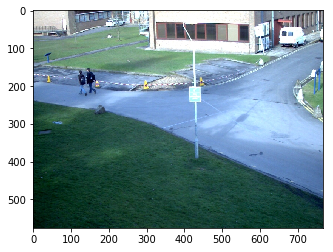

In [53]:
#seleciona uma imagem para a fase de test (subtrair foreground e background da mesma)

test_img = cv.imread(TEST_DIR + test_list[8], 1)
test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)

plt.imshow(test_img)


In [54]:
EPS2 = 20

test_img = test_img.astype(np.float32)

mask = test(test_img, codebooks, 9)

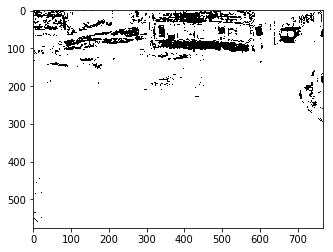

In [56]:
plt.imshow(mask, cmap="gray")

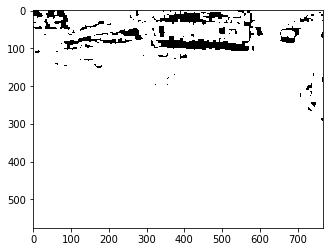

In [57]:
kernel = np.ones((4,4),np.uint8)
kernel2 = np.ones((7,7),np.uint8)
erosion = cv.erode(mask,kernel,iterations= 1)
dilation = cv.dilate(erosion,kernel2,iterations = 1)
plt.imshow(dilation, cmap='gray');